In [ ]:
# @title Install dependencies
# NOTE: some may be missing or unnecessary because the code below has been changing quickly
!sudo apt-get install -y ffmpeg --quiet
!pip install librosa --quiet
!pip install torchaudio --quiet

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import argparse
import os
import tqdm
import scipy.ndimage as nd
import os
import torchvision
import torchaudio
import IPython

In [2]:
# Helper functions --> thanks NMA
import random

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

def stat_img(img, id=None):
    if id is None:
        id = "Image"
    print(f"{id}:  {type(img)} of shape {img.shape} and dtype {img.dtype}")
    print(f"{id}:  max value: {img.max()}  min value: {img.min()}")
    print(f"{id}:  mean: {img.mean():.6f}  std: {img.std():.6f}")
    plt.axis('off')
    plt.imshow(img)
    plt.show()    

def plot_spectrogram(spec, origin='lower', aspect='auto', title=None):
    fig, axs = plt.subplots(1, 1)
    if title is None:
        title = "Spectrogram"
    axs.set_title(title)
    axs.set_ylabel('bins')
    axs.set_xlabel('frame')
    im = axs.imshow(spec, origin=origin, aspect=aspect)
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

set_seed(2021)
print(torch.cuda.is_available())
DEVICE = set_device()

Random seed 2021 has been set.
True
GPU is enabled in this notebook.


In [3]:
# Dataset Location & Hyperparameters

# change this to the location of the data directory on your drive
datapath = './data'
datapath = os.path.abspath(datapath)


# HYPERPARAMETERS

# number of gradient ascent steps per octave
iterations = 20
iterations = 50
iterations=200
iterations=100

# the layer whose activation we will maximize
dream_layer = 22
#dream_layer = 34 # vgg19 has 36 layers

# the class we want to maximize


# --lr            learning rate
lr = 1e-02

# --octave_scale  image scale between octaves
# the image is scaled to progressively smaller fields of view
octave_scale = 1.4

# --num_octaves   number of octaves to zoom in to the image, if your image is not big don't make this too large
num_octaves = 6
num_octaves = 10
num_octaves = 8
num_octaves = 2
num_octaves = 5

In [4]:
# Get the class names for imagenet

import json

fp = "models/imagenet1000_clsidx_to_labels.txt"
fp = os.path.join(datapath, fp)

with open(fp) as f:
    inet_classes = json.load(f)

inet_classes = np.array([inet_classes[key] for key in inet_classes])


def classify(X, model, num_predictions=5, device=None):
    print(type(X))
    if type(X) == np.ndarray:
        X = torch.tensor(X, dtype=torch.float).permute(2,0,1).unsqueeze(dim=0)
        
    print("Device is ", device)
    if device is not None:
        X = X.to(device)
        print("Move X to ", X.device)
        
    prediction = model(X).squeeze()
    prediction = prediction.cpu().numpy()
    top = np.argsort(prediction, axis=0)[-num_predictions:]
    top = { prediction[idx]: (idx, inet_classes[idx]) for idx in top }

    print("Model thinks...")
    #print(f'Max prediction: {prediction.max():.5f}')
    for (score, label) in sorted(top.items(), reverse=True):
        print(f'{score:.5f} confidence, class {label[0]}: {label[1]}')
    
    return prediction

In [5]:
# Create the model
vgg16 = torchvision.models.vgg16()

# Load the pretrained weights
vgg16_path = os.path.join(datapath, 'models/vgg16.pth')
vgg16_state_dict = torch.load(vgg16_path)
vgg16.load_state_dict(vgg16_state_dict)

# Freeze parameters (we are not doing any model training here!)
for param in vgg16.parameters():
    param.requires_grad = False

#print(vgg16)

Image loaded from:  /home/jon/Drive/LEVERHULME/COURSES/NEUROMATCH2021/HallucinatingGANs/Code/data/misc/notaflower.png
Image:  <class 'numpy.ndarray'> of shape (512, 512, 3) and dtype float32
Image:  max value: 1.0  min value: 0.0
Image:  mean: 0.457089  std: 0.199547


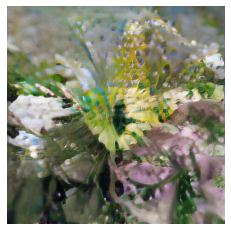

<class 'torch.Tensor'>
Device is  None


/home/jon/miniconda3/envs/data/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448238472/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Model thinks...
6.11056 confidence, class 6: stingray
5.94406 confidence, class 395: gar, garfish, garpike, billfish, Lepisosteus osseus
5.92905 confidence, class 4: hammerhead, hammerhead shark
5.86724 confidence, class 394: sturgeon
5.77504 confidence, class 391: coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch


In [6]:
# Import an image from the drive...
import matplotlib.image as im

#input_image_path = 'misc/notadog.png'
input_image_path = 'misc/notaflower.png'
input_image_path = os.path.join(datapath, input_image_path)

input_image = im.imread(input_image_path)

# summarize image
print("Image loaded from: ", input_image_path)
input_image = input_image[:,:,:3] # PNGs often have an alpha channel, remove it
stat_img(input_image)
input_image_tensor = torch.tensor(input_image).permute(2,0,1).unsqueeze(dim=0)

prediction = classify(input_image_tensor, vgg16, 5)

In [116]:
# Let's try using a spectrogram...
gztan = torchaudio.datasets.GTZAN(os.path.abspath(datapath), download=False)

torch.Size([661794])
tensor(0.) tensor(17778.1992)
Image:  <class 'torch.Tensor'> of shape torch.Size([513, 862, 3]) and dtype torch.float32
Image:  max value: 1.0  min value: 0.0
Image:  mean: 0.252042  std: 0.372002


/tmp/ipykernel_11348/1925402305.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stft_tensor = torch.tensor(stft).reshape(3, 513, -1)


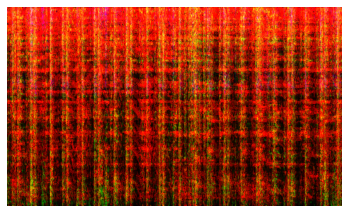

Model thinks...
764.80518 confidence, class 920: traffic light, traffic signal, stoplight
676.38983 confidence, class 818: spotlight, spot
530.66583 confidence, class 607: jack-o-lantern
494.64340 confidence, class 880: unicycle, monocycle
484.07391 confidence, class 862: torch


In [177]:
waveform, samplerate, label = gztan[0]
num_chan, num_frames = waveform.shape
waveform = waveform.squeeze() # remove the channel dimension
print(waveform.shape)

n_fft = 1024
n_mels = 128
win_length = None
hop_length = 256 # smaller hop size leads to better reconstruction but takes longer to compute
power = 2.0 # squared power magnitude spectrogram

get_stft = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=power,
)
amp_to_db = torchaudio.transforms.AmplitudeToDB('power')

stft = get_stft(waveform)
#stft_db = amp_to_db(stft)

# how to normalize?
print(stft.min(), stft.max())

stft_tensor = torch.tensor(stft).reshape(3, 513, -1)
stat_img(stft_tensor.clip(0,1).permute(1,2,0))
predict = classify(stft_tensor.unsqueeze(dim=0), vgg16, 5)

In [ ]:
# Dreaming by Layer Activation, build a partial network

# Convert the nn layers to a basic python list
layers = list(network.features.children())

# Make a new Sequential function for the layers of the network 
#            up to and including the layer we want to maximize
partial_network = nn.Sequential(*layers[:(dream_layer + 1)])

print(partial_network)

Image:  <class 'numpy.ndarray'> of shape (512, 512, 3) and dtype float32
Image:  max value: 1.0  min value: 0.0
Image:  mean: 0.391351  std: 0.168023


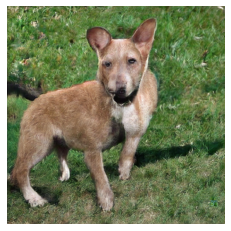

True


In [215]:
# Dreaming by Classifier Activation
stat_img(input_image)

In [7]:
# More helper functions

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

normalize = torchvision.transforms.Normalize(mean, std)
preprocess = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize])


def deprocess(image_np):
    print("Deproccess, incoming image: ", type(image_np), image_np.shape)
    image_np = image_np.transpose(1, 2, 0)
    image_np = image_np * std.reshape((1, 1, 3)) + mean.reshape((1, 1, 3))
    image_np = np.clip(image_np, 0.0, 255.0)
    return image_np

def clip(image_tensor):
    for c in range(3):
        m, s = mean[c], std[c]
        image_tensor[0, c] = torch.clamp(image_tensor[0, c], -m / s, (1 - m) / s)
    return image_tensor

In [13]:
# Extract image representations for each octave
# NOTE: We expect here that input_image is a numpy array with dimensions HEIGHT x WIDTH x CHANNELS(3)

theimage = input_image[:,:,:3]

# dream on noise...
#theimage = np.random.rand(512, 512, 3)

octaves = [theimage]
print(octaves[-1].shape)
for i in range(num_octaves - 1):
    zoom_factor = (1 / octave_scale, 1 / octave_scale, 1) # one per axis (H, W, CHANNEL)
    #print(i, octaves[-1])
    print(i, type(octaves[-1]), octaves[-1].shape, zoom_factor)     
    img = nd.zoom(octaves[-1], zoom_factor, order=1)
    octaves.append(img)

(512, 512, 3)
0 <class 'numpy.ndarray'> (512, 512, 3) (0.7142857142857143, 0.7142857142857143, 1)
1 <class 'numpy.ndarray'> (366, 366, 3) (0.7142857142857143, 0.7142857142857143, 1)
2 <class 'numpy.ndarray'> (261, 261, 3) (0.7142857142857143, 0.7142857142857143, 1)
3 <class 'numpy.ndarray'> (186, 186, 3) (0.7142857142857143, 0.7142857142857143, 1)


Dreaming:   0%|                                                         | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_7775/2347349848.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True, dtype=torch.float, device=DEVICE)


Dream of 149 dugong, Dugong dugon ... (133, 133, 3)
0: activation torch.Size([]): -4.935123920440674
50: activation torch.Size([]): 474.34844970703125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 133, 133)
Image:  <class 'numpy.ndarray'> of shape (133, 133, 3) and dtype float64
Image:  max value: 1.5222378120422362  min value: 0.0
Image:  mean: 0.456171  std: 0.204048


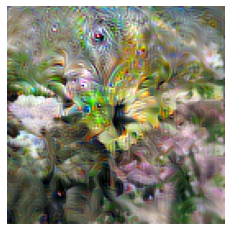

Dreaming:  20%|█████████▊                                       | 1/5 [00:02<00:10,  2.74s/it]

Dream of 149 dugong, Dugong dugon ... (186, 186, 3)
0: activation torch.Size([]): 47.673072814941406
50: activation torch.Size([]): 739.8585205078125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 186, 186)
Image:  <class 'numpy.ndarray'> of shape (186, 186, 3) and dtype float64
Image:  max value: 2.089471939086914  min value: 0.0
Image:  mean: 0.456330  std: 0.217767


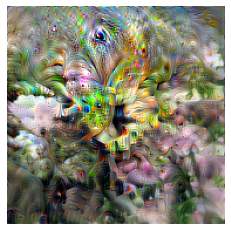

Dreaming:  40%|███████████████████▌                             | 2/5 [00:06<00:09,  3.32s/it]

Dream of 149 dugong, Dugong dugon ... (261, 261, 3)
0: activation torch.Size([]): 59.54372024536133
50: activation torch.Size([]): 822.9630126953125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 261, 261)
Image:  <class 'numpy.ndarray'> of shape (261, 261, 3) and dtype float64
Image:  max value: 2.2270044999122622  min value: 0.0
Image:  mean: 0.456512  std: 0.226957


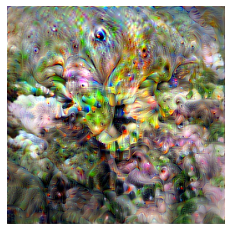

Dreaming:  60%|█████████████████████████████▍                   | 3/5 [00:11<00:08,  4.25s/it]

Dream of 149 dugong, Dugong dugon ... (366, 366, 3)
0: activation torch.Size([]): 68.78861999511719
50: activation torch.Size([]): 786.285888671875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 366, 366)
Image:  <class 'numpy.ndarray'> of shape (366, 366, 3) and dtype float64
Image:  max value: 2.202459379196167  min value: 0.0
Image:  mean: 0.456937  std: 0.234207


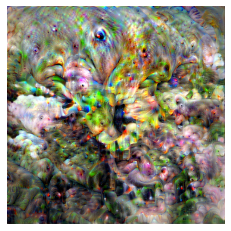

Dreaming:  80%|███████████████████████████████████████▏         | 4/5 [00:21<00:06,  6.25s/it]

Dream of 149 dugong, Dugong dugon ... (512, 512, 3)
0: activation torch.Size([]): 63.78872299194336
50: activation torch.Size([]): 839.8428344726562


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 512, 512)
Image:  <class 'numpy.ndarray'> of shape (512, 512, 3) and dtype float64
Image:  max value: 2.609938455581665  min value: 0.0
Image:  mean: 0.457483  std: 0.240833


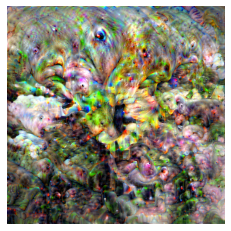

Dreaming: 100%|█████████████████████████████████████████████████| 5/5 [00:38<00:00,  7.67s/it]

Output:  (512, 512, 3) <class 'numpy.ndarray'>


In [14]:
def dream(image, model, iterations, lr, unit=None):
    """ Updates the image to maximize outputs for n iterations """
    
    if unit is None:
        print(f"Dreaming ... {image.shape}")
    else:
        print(f"Dream of {unit} {inet_classes[unit]} ... {image.shape}")

    image = preprocess(image)

    # Convert the numpy array image into a requires_grad=True Tensor that we will optimize
    image = torch.tensor(image, requires_grad=True, dtype=torch.float, device=DEVICE)
            
    # Optimization loop
    for i in range(iterations):
        model.zero_grad()
        out = model(image.unsqueeze(0))

        if unit is None:
            # Dreaming on a whole layer 
            gain = out.norm()
        else:
            # Dreaming on a specific output neuron...
            gain = out[0][unit]
            
        if i % 50 == 0:
            print(f"{i}: activation {gain.shape}: {gain}")
                        
        gain.backward()
        
        # Update image using gradients...
        #print(i, image.grad)
        # print("data: ", image.data)
        #avg_grad = np.abs(image.grad.data.cpu().numpy()).mean()
        with torch.no_grad():
            absgrad = torch.abs(image.grad)
            norm_lr = lr / absgrad.mean()
            image += norm_lr * image.grad
            image = clip(image)
        
        image.grad.zero_()

    return deprocess(image.detach().cpu().numpy())


# change this to dream on another class, or set to None to dream on a layer
class_number = 149

themodel = vgg16.to(DEVICE)
detail = np.zeros_like(octaves[-1])

for octave, octave_base in enumerate(tqdm.tqdm(octaves[::-1], desc="Dreaming")):
    if octave > 0:
        # Fit the detail (by zooming) to the shape of the current octave image
        zoom_factor = np.array(octave_base.shape) / np.array(detail.shape)
        detail = nd.zoom(detail, zoom_factor, order=1)
    # Add deep dream detail from previous octave to new base
    img = octave_base + detail
    
    # Get new deep dream image
    dreamed_image = dream(img, themodel, iterations, lr, unit=class_number)
    
    stat_img(dreamed_image)
    
    # Extract deep dream details
    detail = dreamed_image - octave_base

#dreamed_image = deprocess(dreamed_image)
print("Output: ", dreamed_image.shape, type(dreamed_image))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dreamed image (512, 512, 3) max: 2.609938455581665  min: 0.0
<class 'numpy.ndarray'>
Device is  cuda
Move X to  cuda:0
Model thinks...
314.81448 confidence, class 149: dugong, Dugong dugon
206.49677 confidence, class 344: hippopotamus, hippo, river horse, Hippopotamus amphibius
176.13875 confidence, class 390: eel
170.79750 confidence, class 394: sturgeon
164.83041 confidence, class 296: ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus
Scaled image max: 1.0  min: 0.0


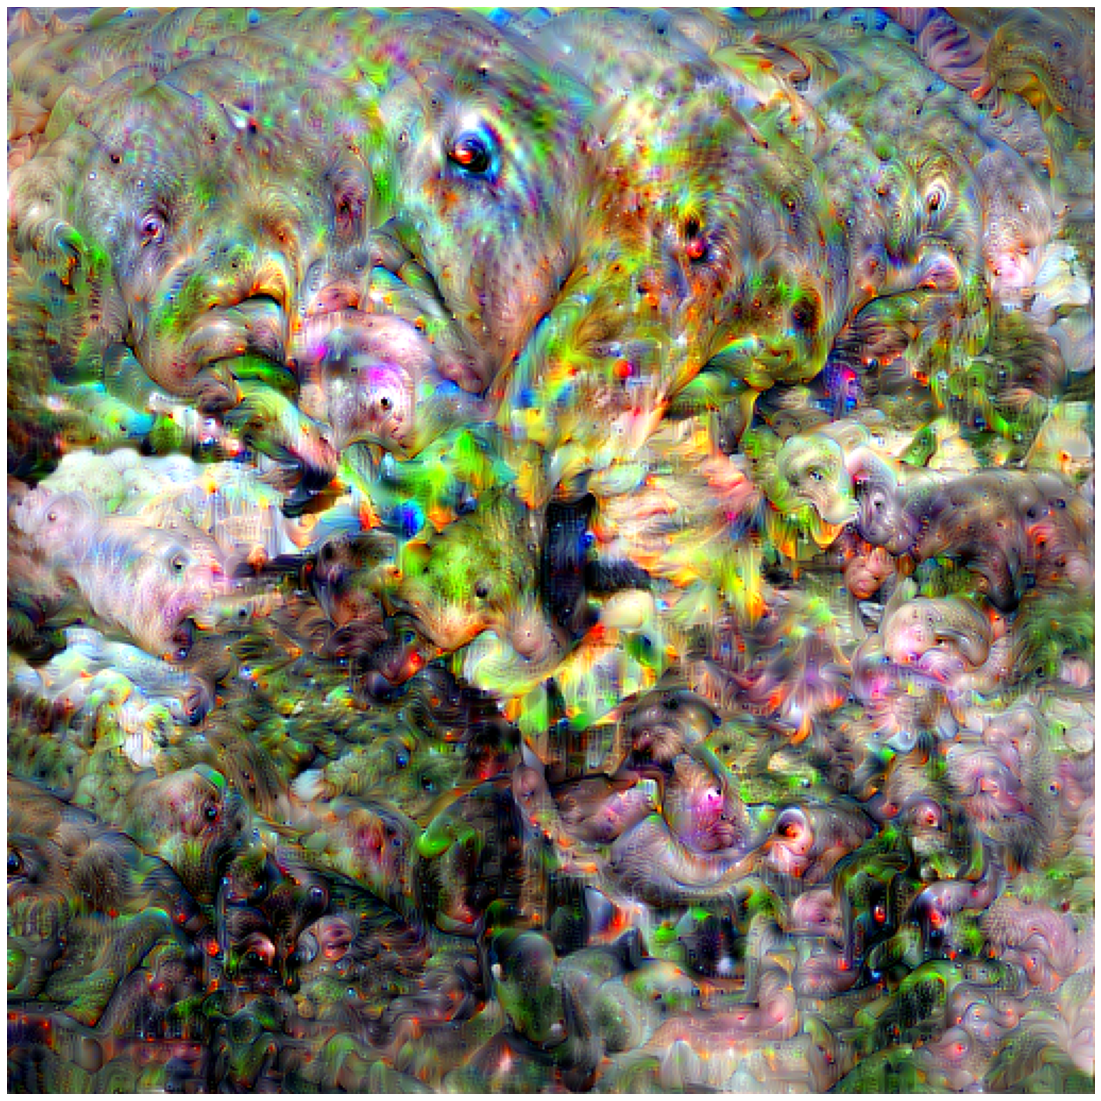

In [15]:
dream_name = "flower_dugong"

import time
timestr = time.strftime("%Y%m%d-%H%M%S")


print(f"Dreamed image {dreamed_image.shape} max: {dreamed_image.max()}  min: {dreamed_image.min()}")

classify(dreamed_image, vgg16, 5, device=DEVICE)

dreamed_scaled = dreamed_image.copy()

if dreamed_scaled.min() < 0:
    dreamed_scaled += np.abs(dreamed_scaled.min())
if dreamed_scaled.max() > 1.0:
    dreamed_scaled = dreamed_scaled / dreamed_scaled.max()

print(f"Scaled image max: {dreamed_scaled.max()}  min: {dreamed_scaled.min()}")


# Save and plot image
outputdir = os.path.join(datapath, 'dreams')
os.makedirs(outputdir, exist_ok=True)
filename = f"{dream_name}_" + timestr + '.png'
plt.figure(figsize=(20, 20))
plt.imshow(dreamed_image)
plt.axis('off')
plt.imsave(f"{outputdir}/{filename}", dreamed_scaled)
plt.show()

In [13]:
# Reconstruct Audio from spectrogram

def play_audio(waveform, samplerate):
  if type(waveform) == torch.Tensor:
      waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(IPython.display.Audio(data=waveform, rate=samplerate))
  elif num_channels == 2:
    display(IPython.display.Audio(data=(waveform[0], waveform[1]), rate=samplerate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

dreamed_spec = np.flip(dreamed_image, axis=0)
dreamed_spec = np.reshape(dreamed_spec, (513, -1))
dreamed_spec = torch.tensor(dreamed_spec, device='cpu')
print(dreamed_spec.shape)

resynth_griffin_lim = torchaudio.transforms.GriffinLim(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)

resynthesized_waveform = resynth_griffin_lim(dreamed_spec)

play_audio(resynthesized_waveform.unsqueeze(dim=0), samplerate)

ValueError: cannot reshape array of size 786432 into shape (513,newaxis)